In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint, solve_ivp
from scipy.stats import beta
from scipy.linalg import expm

from local_functions import *

import itertools, time, random
from scipy.stats import wasserstein_distance

In [2]:
def random_combinations(iterable, r, max_iter=5000):
    # from: https://stackoverflow.com/questions/22229796/choose-at-random-from-combinations
    i = 0
    pool = tuple(iterable)
    n = len(pool)
    rng = range(n)
    while i < max_iter:
        i += 1
        yield [pool[j] for j in random.sample(rng, r)] 
        
def kvariance(arr, k, approximate=True, max_iter=5000):
    
    if approximate:
        sets1 = random_combinations(arr, k, max_iter=max_iter)
        sets2 = random_combinations(arr, k, max_iter=max_iter)
        wsds = [wasserstein_distance(set1, set2) 
                for set1, set2 in zip(sets1, sets2)]
        
    else:
        ksets = itertools.combinations(arr, k)
        wsds = [wasserstein_distance(set1, set2) 
                for set1, set2 in itertools.product(ksets, repeat=2)]
        
    kvariance = k/2*np.mean(wsds) # would need to be adjust if data is not 1D
    return kvariance

def kvariancePlot(arr, kmax=None, approximate=True, max_iter=5000):
    
    if kmax is None:
        kmax = len(arr)
        
    krange = range(1, kmax+1)
    
    values = [kvariance(arr, k, approximate=approximate, 
                        max_iter=max_iter) for k in krange]
    
    plt.plot(krange,values)
    return krange, values

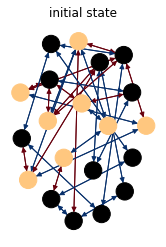

In [13]:
# set time steps
t0, t1, dt = 0, 1.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20) 
x0[4:8], x0[12:16] = 1, 1
np.random.shuffle(x0)
scale = 1
x0 = x0*scale# + np.random.normal(size=20)

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=False, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', 
               intention=False, coevolving=True, fix_indegree=True, alpha=20)
#plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], coevolving=True)
plt.figure()
plt.subplot(121)
plt.title('initial state')
fixed_pos = nx.spring_layout(nx.complete_graph(20))
drawState(dat, 0, intention=False, fixed_pos=fixed_pos)
plt.savefig('state0.png', dpi=300)

{0: array([-0.34908495,  0.44463633]),
 1: array([ 0.70176454, -0.96418361]),
 2: array([ 0.50346344, -1.        ]),
 3: array([-0.29444319,  0.52017839]),
 4: array([-0.49096617,  0.49081808]),
 5: array([ 0.69591444, -0.82818071]),
 6: array([ 0.59820012, -0.99367628]),
 7: array([-0.49476526,  0.69728696]),
 8: array([-0.43921084,  0.60371885]),
 9: array([ 0.50841673, -0.92724179]),
 10: array([-0.40738284,  0.53166631]),
 11: array([-0.41451747,  0.67402098]),
 12: array([-0.27688337,  0.63384194]),
 13: array([-0.39670737,  0.75090699]),
 14: array([ 0.51835657, -0.86057518]),
 15: array([-0.34621077,  0.59880063]),
 16: array([-0.54002624,  0.57775475]),
 17: array([ 0.6351351 , -0.88655059]),
 18: array([ 0.59413739, -0.76350391]),
 19: array([-0.30518985,  0.70028188])}

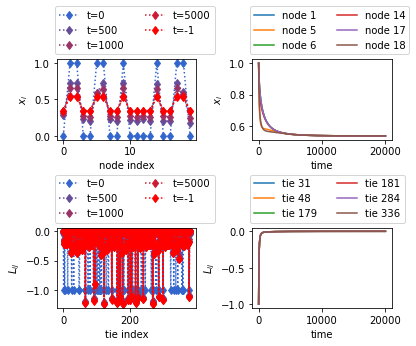

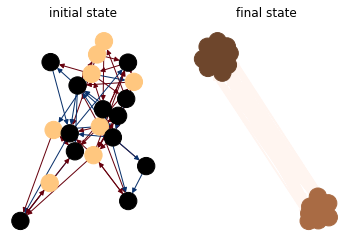

In [6]:
# set time steps
t0, t1, dt = 0, 20.001, 0.001 

# set bimodal initial value
x0 = np.zeros(20)
x0[4:8], x0[12:16] = 1, 1
np.random.shuffle(x0)
scale = 1
x0 = x0*scale

# construct directed adjacency matrix of random graph
# (from previous tries, we know that setting seed=4 gives us a strongly connected graph)
A = nx.to_numpy_array(nx.gnp_random_graph(20, 0.15, directed=True, seed=4)) 

# run simulations
dat = simulate(A=A, x0=x0, t0=t0, t1=t1, dt=dt, degree='in', 
               intention=False, coevolving=True, fix_indegree=True, alpha=20)
plotSim(dat, lines=[[0, 500, 1000, 5000, -1], 6], coevolving=True)
plt.figure()
plt.subplot(121)
plt.title('initial state')
drawState(dat, 0, intention=False)

plt.subplot(122)
plt.title('final state')
drawState(dat, -1, intention=False)

Time per iteration: 2.683178424835205


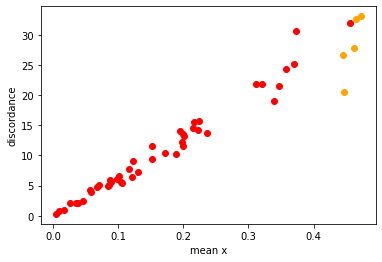

In [13]:
# mean x and discordance
output1 = plotSweepTrajectories(max_iter=50, trajectories=False)

Time per iteration: 21.08624529838562


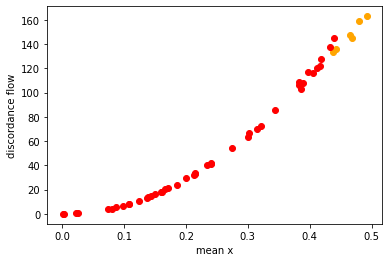

In [14]:
# mean x and discordance flow
output1 = plotSweepTrajectories(max_iter=50, trajectories=False, 
    fun2=lambda A,x,a,s,m : np.sum(squaredDistanceMatrix(x)*expm(A)), varname2='discordance flow')

Time per iteration: 1.0239617824554443


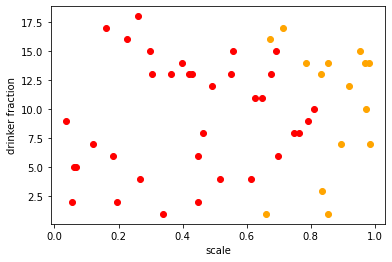

In [15]:
# scale and mx
n = 20
output3 = plotSweepTrajectories(max_iter=50, trajectories=False, gen_mx=lambda: np.random.randint(1,n-1), 
    fun1=lambda A,x,a,s,m : s, varname1='scale', fun2=lambda A,x,a,s,m : m, varname2='drinker fraction')

Time per iteration: 0.21639537811279297


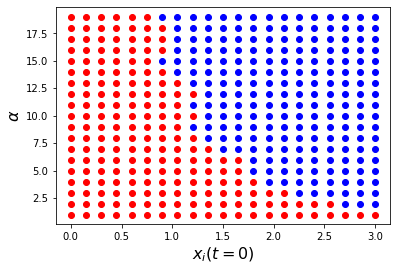

In [5]:
# scale and alpha
def list2Gen(li):
    def f():
        for el in li:
            yield el
    g = f().__next__
    return g

scales = np.arange(0,3.1,0.15)
alphas = np.arange(1,20,1)

output4 = plotSweepTrajectories(max_iter=len(scales)*len(alphas), trajectories=False, 
    gen_scale=list2Gen(np.tile(scales, len(alphas))),
    gen_alpha=list2Gen(np.repeat(alphas, len(scales))), 
    fun1=lambda A,x,a,s,m: s, varname1=r'$x_i(t=0)$', fun2=lambda A,x,a,s,m: a, varname2=r'$\alpha$')
plt.savefig('alpha-scale.png')

In [3]:
import numpy as np
np.argmax(np.arange(10)>5)

6

In [ ]:
a = np.arange(10)
